In [1]:
import mxnet as mx
from mxnet import nd

In [2]:
probabilities = nd.ones(6) / 6
nd.sample_multinomial(probabilities)


[3]
<NDArray 1 @cpu(0)>

In [3]:
print(nd.sample_multinomial(probabilities, shape=(10)))
print(nd.sample_multinomial(probabilities, shape=(5, 10)))


[3 4 5 3 5 3 5 2 3 3]
<NDArray 10 @cpu(0)>

[[2 2 1 5 0 5 1 2 2 4]
 [4 3 2 3 2 5 5 0 2 0]
 [3 0 2 4 5 4 0 5 5 5]
 [2 4 4 2 3 4 4 0 4 3]
 [3 0 3 5 4 3 0 2 2 1]]
<NDArray 5x10 @cpu(0)>


In [4]:
rolls = nd.sample_multinomial(probabilities, shape=(1000))

In [6]:
counts = nd.zeros((6, 1000))
totals = nd.zeros(6)
for i, roll in enumerate(rolls):
    totals[int(roll.asscalar())] += 1
    counts[:, i] = totals

In [7]:
counts


[[   0.    0.    0. ...,  165.  166.  167.]
 [   1.    1.    1. ...,  168.  168.  168.]
 [   0.    0.    0. ...,  175.  175.  175.]
 [   0.    0.    0. ...,  159.  159.  159.]
 [   0.    1.    2. ...,  158.  158.  158.]
 [   0.    0.    0. ...,  173.  173.  173.]]
<NDArray 6x1000 @cpu(0)>

In [8]:
totals / 1000


[ 0.167       0.168       0.175       0.15899999  0.15800001  0.17299999]
<NDArray 6 @cpu(0)>

In [9]:
x = nd.arange(1000).reshape((1, 1000)) + 1
estimates = counts/ x
print(estimates[:, 0])
print(estimates[:, 1])
print(estimates[:, 100])


[ 0.  1.  0.  0.  0.  0.]
<NDArray 6 @cpu(0)>

[ 0.   0.5  0.   0.   0.5  0. ]
<NDArray 6 @cpu(0)>

[ 0.1980198   0.15841584  0.17821783  0.18811882  0.12871288  0.14851485]
<NDArray 6 @cpu(0)>


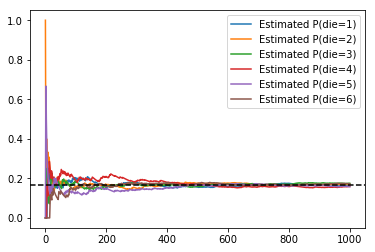

In [11]:
from matplotlib import pyplot as plt
plt.plot(estimates[0, :].asnumpy(), label="Estimated P(die=1)")
plt.plot(estimates[1, :].asnumpy(), label="Estimated P(die=2)")
plt.plot(estimates[2, :].asnumpy(), label="Estimated P(die=3)")
plt.plot(estimates[3, :].asnumpy(), label="Estimated P(die=4)")
plt.plot(estimates[4, :].asnumpy(), label="Estimated P(die=5)")
plt.plot(estimates[5, :].asnumpy(), label="Estimated P(die=6)")
plt.axhline(y=0.16666, color='black', linestyle='dashed')
plt.legend()
plt.show()

In [12]:
import numpy as np

# we go over one observation at a time (speed doesn't matter here)
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

# Initialize the count statistics for p(y) and p(x_i|y)
# We initialize all numbers with a count of 1 to ensure that we don't get a
# division by zero.  Statisticians call this Laplace smoothing.
ycount = nd.ones(shape=(10))
xcount = nd.ones(shape=(784, 10))

# Aggregate count statistics of how frequently a pixel is on (or off) for
# zeros and ones.
for data, label in mnist_train:
    x = data.reshape((784,))
    y = int(label)
    ycount[y] += 1
    xcount[:, y] += x

# normalize the probabilities p(x_i|y) (divide per pixel counts by total
# count)
for i in range(10):
    xcount[:, i] = xcount[:, i]/ycount[i]

# likewise, compute the probability p(y)
py = ycount / nd.sum(ycount)

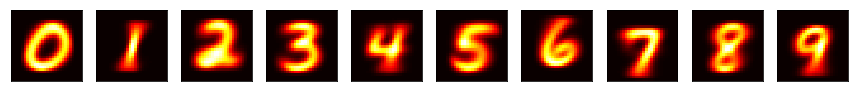


[ 0.09871688  0.11236461  0.09930012  0.10218297  0.09736711  0.09035161
  0.09863356  0.10441593  0.09751708  0.09915014]
<NDArray 10 @cpu(0)>


In [13]:

import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)

plt.show()
print(py)

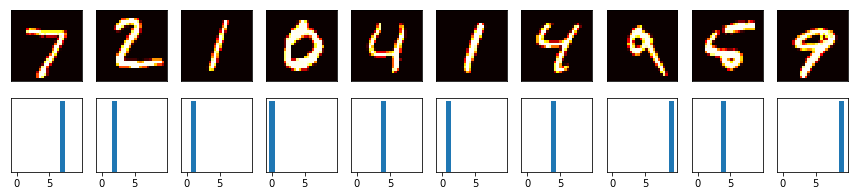

In [14]:
logxcount = nd.log(xcount)
logxcountneg = nd.log(1-xcount)
logpy = nd.log(py)

fig, figarr = plt.subplots(2, 10, figsize=(15, 3))

# show 10 images
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,))
    y = int(label)

    # we need to incorporate the prior probability p(y) since p(y|x) is
    # proportional to p(x|y) p(y)
    logpx = logpy.copy()
    for i in range(10):
        # compute the log probability for a digit
        logpx[i] = nd.dot(logxcount[:, i], x) + nd.dot(logxcountneg[:, i], 1-x)
    # normalize to prevent overflow or underflow by subtracting the largest
    # value
    logpx -= nd.max(logpx)
    # and compute the softmax using logpx
    px = nd.exp(logpx).asnumpy()
    px /= np.sum(px)

    # bar chart and image of digit
    figarr[1, ctr].bar(range(10), px)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).asnumpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1
    if ctr == 10:
        break

plt.show()

In [15]:
import random
for i in range(10):
    print(random.random())

0.2886743824803778
0.7374614494702121
0.057684808185083924
0.4413248332573443
0.272564908801854
0.6830619498284584
0.7794859094869401
0.7986531634115173
0.9032024339164969
0.5425837965546296


In [16]:
for i in range(10):
    print(random.randint(1, 100))

8
98
38
89
88
73
5
38
45
95


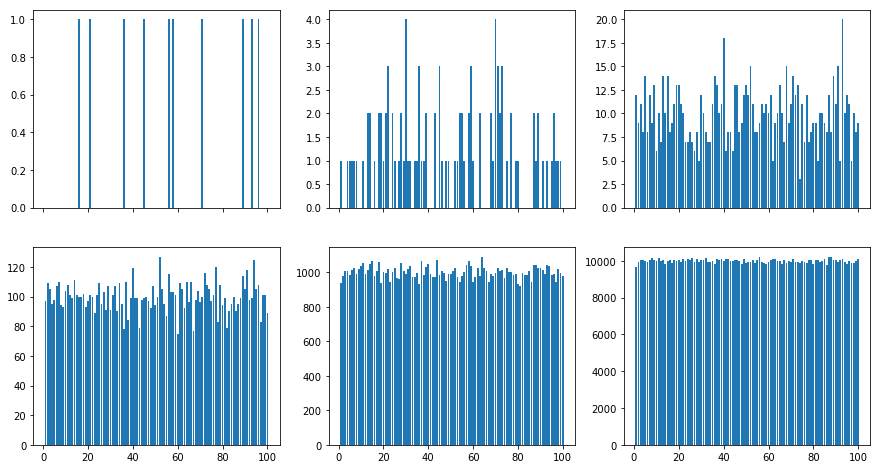

In [17]:
import math

counts = np.zeros(100)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.reshape(6)
# mangle subplots such that we can index them in a linear fashion rather than
# a 2d grid

for i in range(1, 1000001):
    counts[random.randint(0, 99)] += 1
    if i in [10, 100, 1000, 10000, 100000, 1000000]:
        axes[int(math.log10(i))-1].bar(np.arange(1, 101), counts)
plt.show()

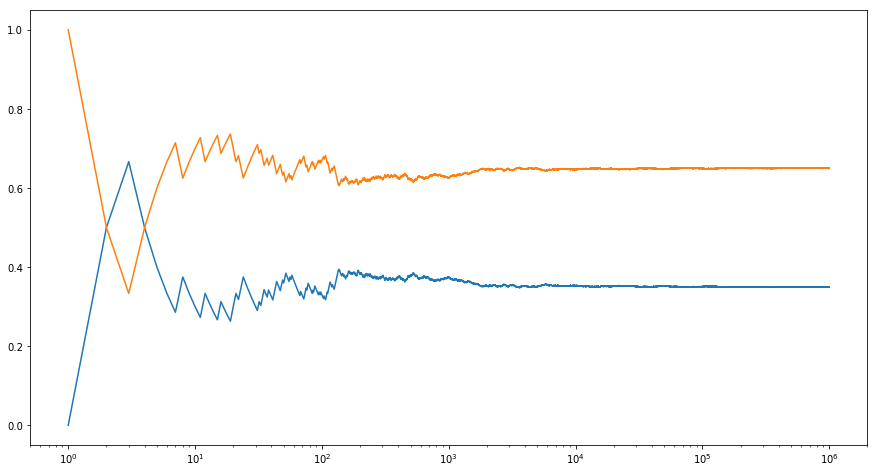

In [18]:
# number of samples
n = 1000000
y = np.random.uniform(0, 1, n)
x = np.arange(1, n+1)
# count number of occurrences and divide by the number of total draws
p0 = np.cumsum(y < 0.35) / x
p1 = np.cumsum(y >= 0.35) / x

plt.figure(figsize=(15, 8))
plt.semilogx(x, p0)
plt.semilogx(x, p1)
plt.show()

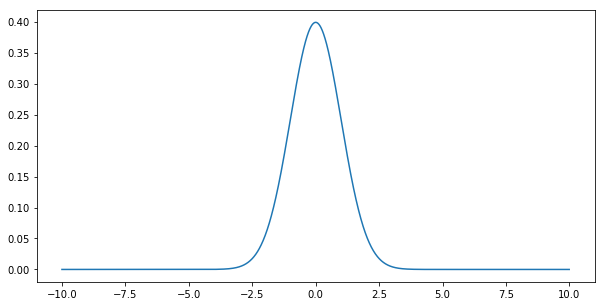

In [19]:
x = np.arange(-10, 10, 0.01)
p = (1/math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)
plt.figure(figsize=(10, 5))
plt.plot(x, p)
plt.show()

mean 0.9, variance 0.49


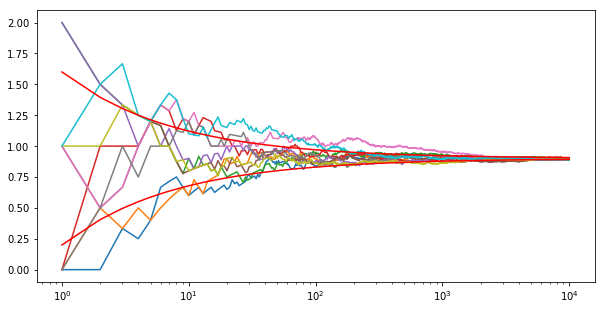

In [20]:
# generate 10 random sequences of 10,000 random normal variables N(0,1)
tmp = np.random.uniform(size=(10000,10))
x = 1.0 * (tmp > 0.3) + 1.0 * (tmp > 0.8)
mean = 1 * 0.5 + 2 * 0.2
variance = 1 * 0.5 + 4 * 0.2 - mean**2
print('mean {}, variance {}'.format(mean, variance))
# cumulative sum and normalization
y = np.arange(1,10001).reshape(10000,1)
z = np.cumsum(x,axis=0) / y

plt.figure(figsize=(10,5))
for i in range(10):
    plt.semilogx(y,z[:,i])

plt.semilogx(y,(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.semilogx(y,-(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.show()